# Demand Side Management for Electricity Consumption

- The project does make use of dataset from https://doi.org/10.24432/C58K54 and is freely available on the address https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption
- This dataset is a time series dataset.
- The size of dataset is around 120MB!

## Libraries Used
1. Sqlite3
2. Plotly
3. Numpy
4. Scipy
5. Pandas
6. Matplotlib

## Necessary Imports

In [34]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as exp
import pandas as pd
from vedo import pyplot

con = sqlite3.connect("./Dataset/Database")

## Get some data from the dataset to get some initial insights.

In [29]:
cur = con.cursor()

avg_consumption = cur.execute("select time, avg(Global_intensity) from household_power_consumption GROUP by time;")
avg_consumption = np.array( avg_consumption.fetchall() )
total_points = len(avg_consumption)

df = pd.DataFrame({"time": avg_consumption[:, 0], "Avg. Consumption (in KJ)": np.array(avg_consumption[:, 1], dtype=np.float32) })


In [31]:
exp.line(df, x="time", y="Avg. Consumption (in KJ)" , width=800, height=600)
# df['Avg. Load'].dtype

## Checking monthly energy consumption


## <center> Average energy consumption by hour </center>

# Fourier Analysis

In [40]:
from scipy.fft import fft, fftfreq
from scipy.signal import convolve
cur = con.cursor()
data = cur.execute('SELECT Global_intensity from household_power_consumption where time = "20:00:00" and Global_intensity is not "?";')    # A LARGE tuple will be returned.
data = cur.fetchall()
 
# Converting it to Numpy array
data = np.array(data,)
data_length = data.shape[0]
data = data.reshape(data_length,)

# Just for single use only
df = pd.DataFrame({"Recording Number": np.arange(data_length), "Load": data})

exp.line(df, x="Recording Number", y="Load", width=800)

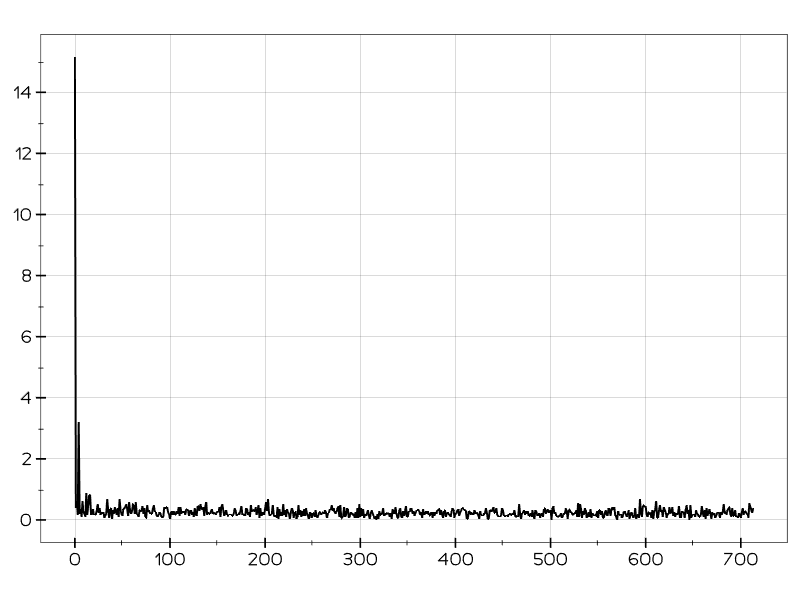

In [17]:
## The fft algorithm is applied here.

fft_data = fft(data)
frequencies = data_length * fftfreq(data_length)

p = pyplot.plot(np.abs(frequencies), 2 * np.abs(fft_data) / data_length )
p.show()

## *<center> Frequency and Amplitudes we get from the signal</center>*

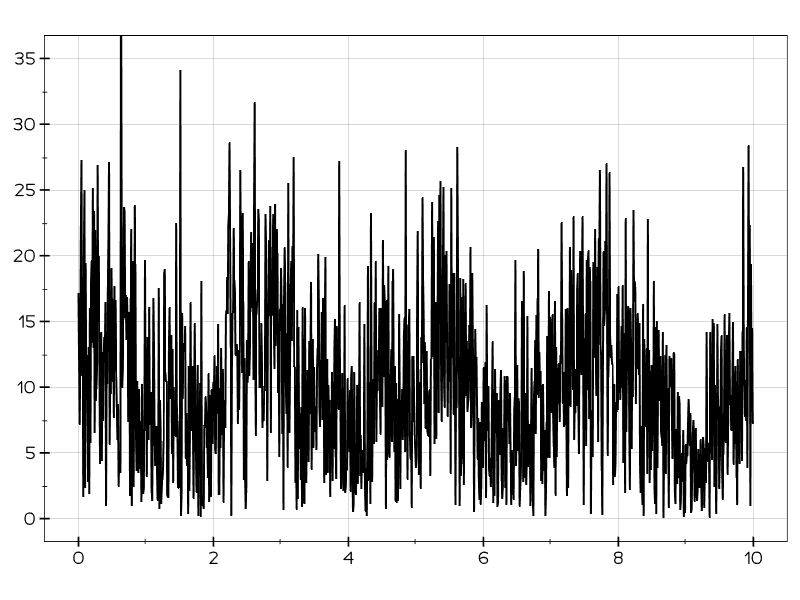

In [18]:
# Now we can find the top frequencies and amplitude making the given signal.

fft_data_mean = np.mean(np.abs(fft_data) )
fft_std = np.std(np.abs(fft_data) )

fft_data_cleaned = fft_data[np.abs(fft_data) > 1 / 2 * fft_data_mean]      # Trying to clean the signal. This signal might have small length then the original signal.


""" Now recreating the signal from the cleaned signal """
clean_signal = np.fft.ifft(fft_data_cleaned)
p = pyplot.plot( np.linspace(0, 10, len(clean_signal) ), np.abs(clean_signal), ylim = [0, 35] )
p.show()

## <center>  Plot created by fft </center>

## Basic FFT Demo

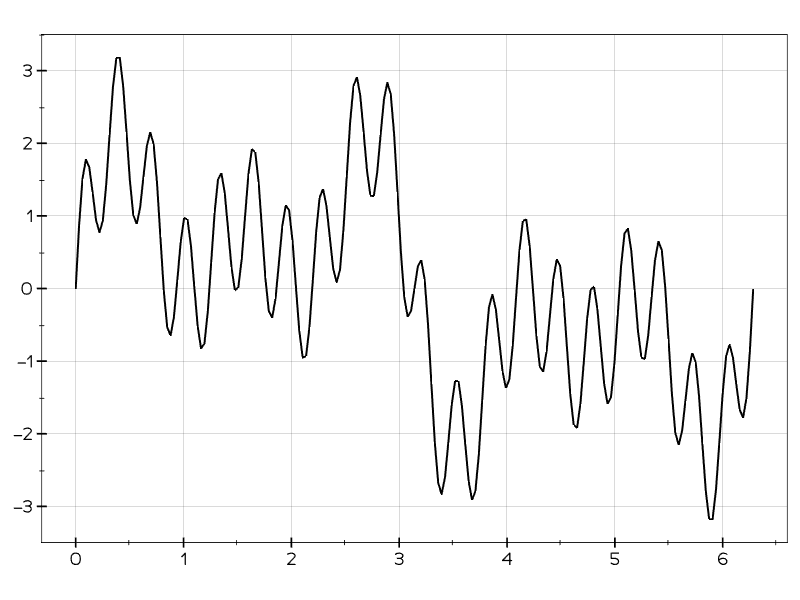

In [133]:
import numpy as np
from scipy.fft import fft, fftfreq
from vedo.pyplot import plot

samples = 201
x = np.linspace(0, 2 * np.pi, samples)
y = np.sin(3*x) + np.sin(5*x) + np.sin(x) + np.sin(20*x)    # The input signal

p = plot(x, y )
p.show()

## <center>  Original Plot</center>

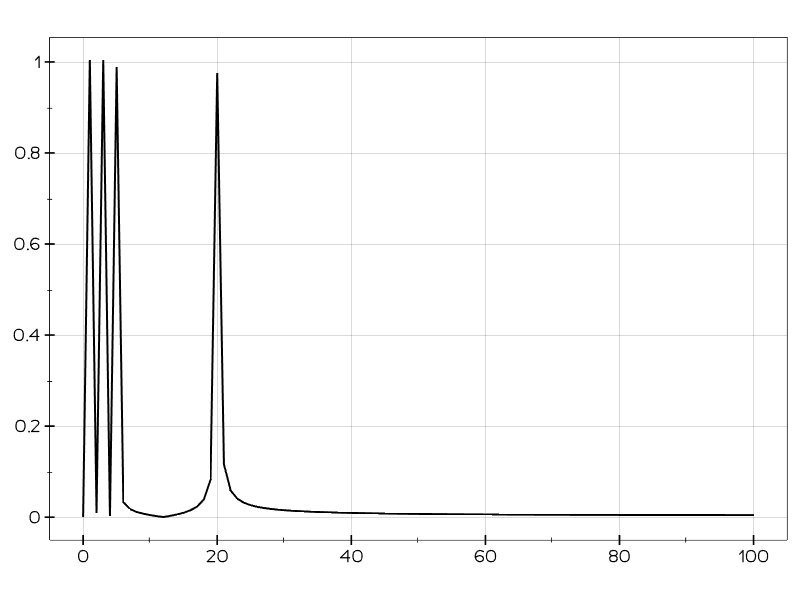

In [134]:
# Since FFT frequencies are repeated, therefore we can discard other half values
fft_y = fft(y)   # FFT applied
freq = samples * fftfreq(samples)

p = plot(np.abs(freq), 2 * np.abs(fft_y) / samples)
p.show()

## <center> Plot of Amplitude vs Frequency </center>

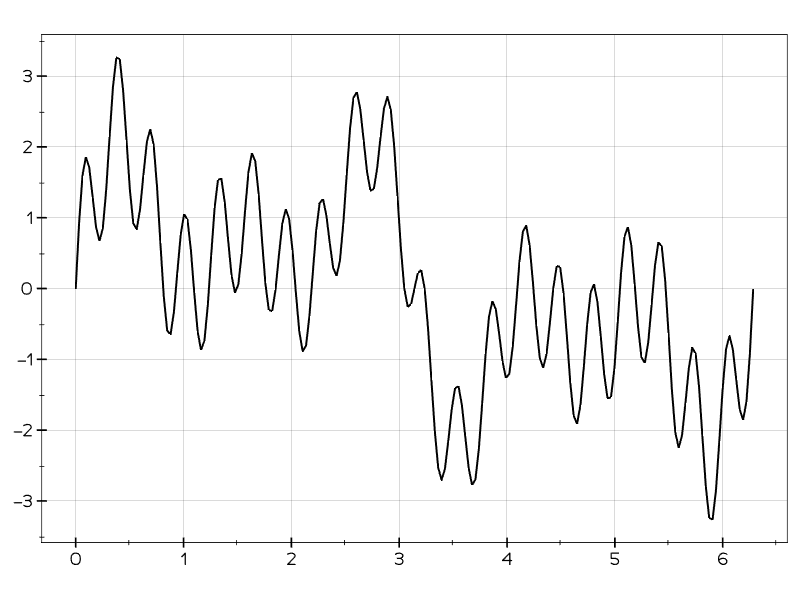

In [152]:
sorted_frequencies = np.argsort( 2 * np.abs(fft_y[:samples // 2]) / samples )[::-1][:5]
sorted_amplitudes = (2 * np.abs(fft_y) / samples)[sorted_frequencies]


# Plotting the function
samples = 201
x = np.linspace(0,2 * np.pi, samples)
y = np.zeros(samples)
for i in range(len(sorted_frequencies) ):
    y += sorted_amplitudes[i] * np.sin(sorted_frequencies[i] * x)

p = plot(x, y)
p.show()

## <center> Recreated Plot </center>

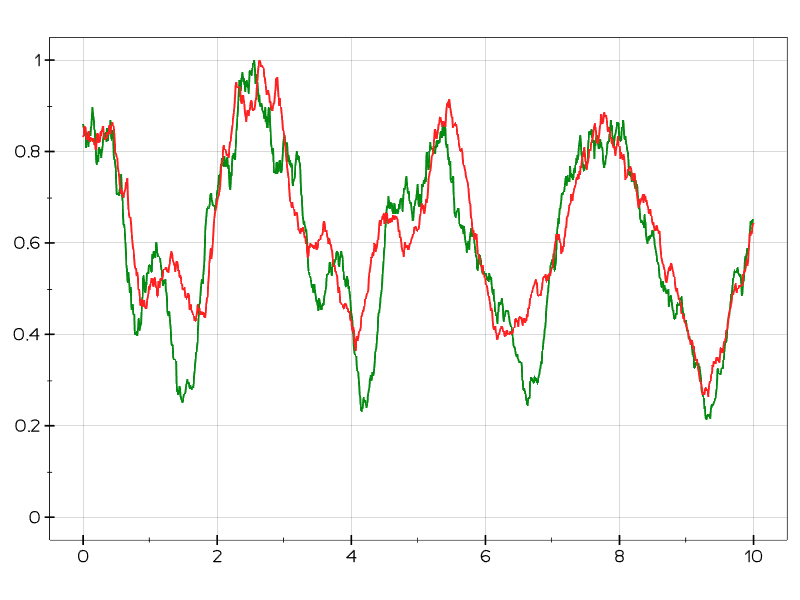

In [19]:
# Trying the correlation on the data.
# Also convolution on the signal to better gain an understanding on the signal.

from scipy.signal import convolve
wave1 = data / np.max(data)
wave2 = np.abs(clean_signal) / np.max(np.abs(clean_signal) )

wave3 = np.ones(50)
output = convolve(wave1, wave3, mode = "valid")
output2 = convolve(wave2, wave3, mode = "valid")


# # This is the signal plot showing the closeness.
# p = pyplot.plot(np.linspace(0, 10, len(wave1 )), wave1, c="g", ylim = [0, 1] )
# p += pyplot.plot(np.linspace(0, 10, len(wave2 )), wave2, c = 'r', ylim = [0, 1])


# This is the correlation plot.
p = pyplot.plot(np.linspace(0, 10, len(output )), output / np.max(output), c = "g", ylim = [0, 1] )      # Original signal
p += pyplot.plot(np.linspace(0, 10, len(output2 )), output2 / np.max(output2), c = "r", ylim = [0, 1])      # Clean signal

p.show()



## Fitting polynomial to data for approximation

/tmp/ipykernel_8730/4190630801.py:3: RankWarning: Polyfit may be poorly conditioned
  a = np.polyfit(np.linspace(0, 10, len(wave2 )), wave2 , 20)      # Returns a * x**20 + b * x**19 + c * x**18 ...


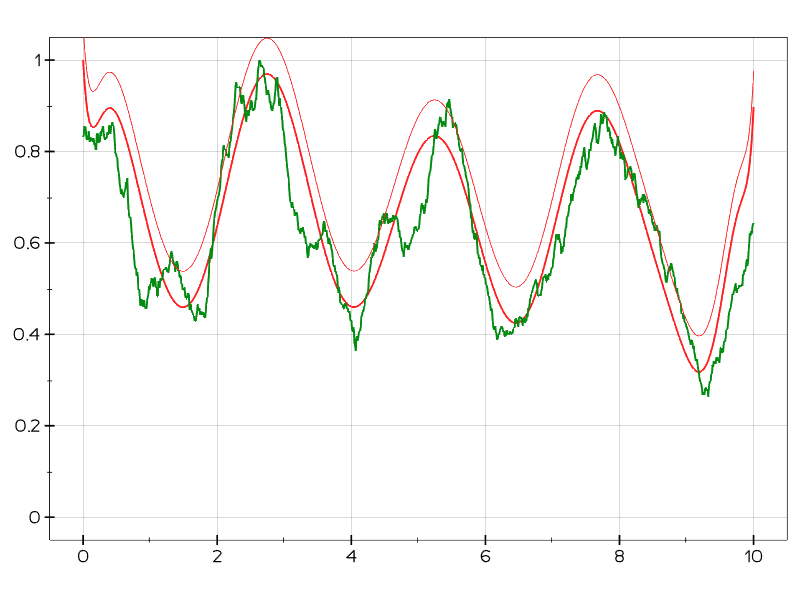

In [20]:
# This fit method used Numpy Library for approximation.

a = np.polyfit(np.linspace(0, 10, len(wave2 )), wave2 , 20)      # Returns a * x**20 + b * x**19 + c * x**18 ...

x = np.linspace(0, 10, len(output2) )
y = np.zeros(len(x) )
for i in range(len(a) ):
    y += a[i] * x ** (len(a) - 1 - i)

# Now normalize y
y = y / np.max(y)

# Plot the fit with original data
p = pyplot.plot(x, y, c = 'r', ylim = [0, 1])
p += pyplot.plot(x, output2 / np.max(output2), c = 'g', ylim = [0, 1] )


# We can also plot the deviation along with the fit polynomial.
deviation = np.std(y - output2 / np.max(output2) )

p += pyplot.plot(x, y + deviation, c = 'r', ylim = [0, 1], lw = 1, xtitle = "Power fluctuation")
# p += pyplot.plot(x, y - deviation, c = 'r', ylim = [0, 1], lw = 0, marker = 'o' )
p.show()

 ### **<center>With 14 percent error, we can predict the average consumption at the given time.</center>**

In [47]:
deviation = np.std( (y - output2) / np.max(output2) )
print("The standard deviation is ->", deviation * 100, "percent" )
# print(len(y), len(output2) )

The standard deviation is -> 14.516234179029322 percent


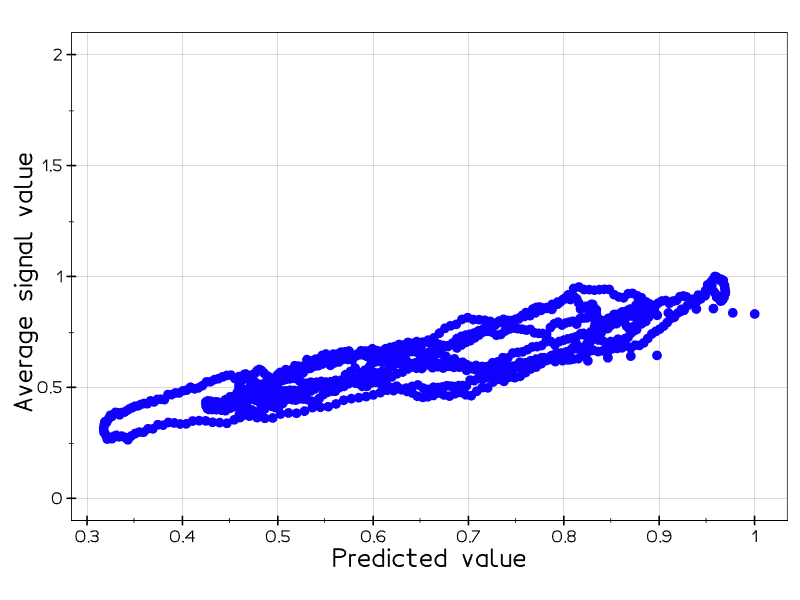

In [21]:
# Since the graph showed some correlation between data of mean + standard deviation and cleaned signal

p = pyplot.plot(y , output2 / np.max(output2) , c='b', lw = 0, xtitle = "Predicted value", ytitle = "Average signal value", ylim = [0, 2])
p.show()

### <center> Relation between predicted and average rolling mean value</center>

## Fitting a line between predicted value and average rolling mean value

In [25]:
# Finding the best fit line for our data

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

x_train, x_test, y_train, y_test = train_test_split(y + deviation, output2)   # Split the data into test train split

model = LinearRegression()
model.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1) )

score = model.score(x_test.reshape(-1, 1), y_test.reshape(-1, 1) )
print( "The score of our model in TEST DATA is :", score)
                                                    

The score of our model in TEST DATA is : 0.6443484041472181


In [26]:
score = model.score(x_train.reshape(-1, 1), y_train.reshape(-1, 1) )
print( "The score of our model in TRAINING DATA itself is :", score)

The score of our model in TRAINING DATA itself is : 0.6647188705198754


## Since our model is a <span style="color: red;">sinusoidal curve</span>. We can also try to fit a sinusoid curve using scipy library.

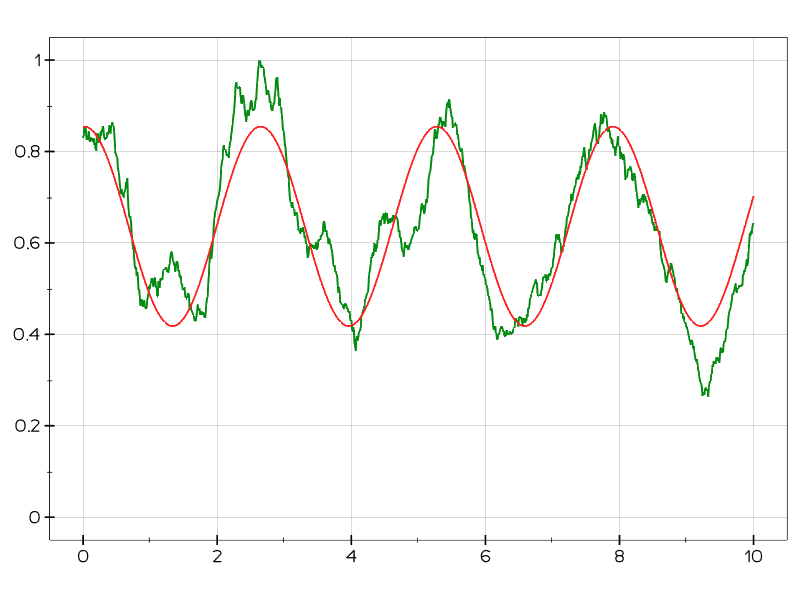

In [22]:
from scipy.optimize import curve_fit

def func(x, a, b, c, d):
    return a * np.sin(b * 2 * x + d) + c

popt, pcov = curve_fit(func, x, output2 / np.max(output2) )


optimized_curve = func(x, *popt)

p = pyplot.plot(x, output2 / np.max(output2), c = 'g', ylim = [0, 1] )
p += pyplot.plot(x, optimized_curve, c = "r", ylim = [0,1] )
p.show()

In [8]:
result = np.std( (optimized_curve - output2) / np.max(output2) )
print("With this method, the standard deviation is", result * 100, "percent" )

With this method, the standard deviation is 12.23422340407231 percent


## In future,We can apply <span style="color: red;">neural networks to better fit</span> the curve.....
## We can also try <span style = 'color: pink;'>RNN and LSTM</span> for this time series data.

In [30]:
a = np.random.randint(0, 1000,(5))

In [31]:
a

array([770, 255, 151, 585, 736])

In [33]:
for i in a:
    print("rolling mean ->", output2[i] / np.max(output2) )
    print("optimized curve ->", y[i])
    print("sinusoid curve is ->", optimized_curve[i])

rolling mean -> 0.6490467980139836
optimized curve -> 0.6491874990598964
sinusoid curve is -> 0.663702726764576
rolling mean -> 0.9580142120329352
optimized curve -> 0.771266565374536
sinusoid curve is -> 0.9337975302260281
rolling mean -> 0.526605342121285
optimized curve -> 0.42234807791521317
sinusoid curve is -> 0.594546826466158
rolling mean -> 0.8412426205655331
optimized curve -> 0.7745302354453018
sinusoid curve is -> 0.9233412549200534
rolling mean -> 0.5489504851378759
optimized curve -> 0.4906827830462119
sinusoid curve is -> 0.5653511554874046
